In [1]:
# Import all the modules required.
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, model_selection
import time

In [2]:
# Extract data from the premier league website.
base_url = 'https://www.premierleague.com'
r = requests.get(base_url + '/clubs')
soup = BeautifulSoup(r.text,'html.parser')

In [3]:
# Create a list that contatins all the links for the different clubs.
index_links = soup.find_all('a',attrs={'class':'indexItem'})
teamlinks = []
for link in index_links:
    squad = link['href'].replace('overview', 'squad')
    teamlinks.append(base_url + squad)

In [4]:
# Using list of team links, need to get the links for each individual player.
playerstats = []
for team in teamlinks:
    squadr = requests.get(team)
    ssoup = BeautifulSoup(squadr.text, 'html.parser')
    players = ssoup.find_all('a', attrs = {'class':'playerOverviewCard active'})
    for player in players:
        a = base_url + player['href']
        playerstats.append(a.replace('overview', 'stats'))
    time.sleep(1)

In [5]:
# Here I am just grouping the players names into a list.
playernames = []
for team in teamlinks:
    squadr = requests.get(team)
    ssoup = BeautifulSoup(squadr.text, 'html.parser')
    for player in ssoup.find_all('h4', attrs = {'class':'name'}):
        playernames.append(player.text)
    time.sleep(1)

In [6]:
# One problem I initially encoutered was that some players had accents in their names on the premier league site, but then lacked these accents on the other site I used - spotrac. To deal with this problem I have also formed and unaccented names list, which can be performed using a module called unidecode.
from unidecode import unidecode
unaccented_names = []
for name in playernames:
    unaccented_names.append(unidecode(name))

In [7]:
# Now we want to collect the relevant statistics for each player. We will create a seperate table for players in each position.
# Lets start with goalkeepers.

# GOALKEEPERS
# First we collect all the stats we want into a list, along with the corresponding tags and attributes from the html doc.
stats_info_g = (('Name', 'div', {'class':'name t-colour'}),
                ('Team', 'div', {'class':'info'}),
                ('Apps', 'span', {'data-stat':'appearances'}),
                ('Wins', 'span', {'data-stat':'wins'}),
                ('Losses', 'span', {'data-stat':'losses'}),
                ('Saves', 'span', {'data-stat':'saves'}),
                ('Penalties saved', 'span', {'data-stat':'penalty_save'}),
                ('Clean sheets', 'span', {'data-stat':'clean_sheet'}),
                ('Goals conceded', 'span', {'data-stat':'goals_conceded'}),
                ('Errors leading to a goal', 'span', {'data-stat':'error_lead_to_goal'}),
                ('Passes', 'span', {'data-stat':'total_pass'}),
                ('Accurate long balls', 'span', {'data-stat':'accurate_long_balls'}),
                ('Yellow cards', 'span', {'data-stat':'yellow_card'}),
                ('Red cards', 'span', {'data-stat':'red_card'}),
                ('Fouls', 'span', {'data-stat':'fouls'}),
                )

# Create an empty dictionary of lists to contain the stats for each player
stats_dict_g = {stat: [] for stat, tags, attrs in stats_info_g}

# Now fill this dictionary with the relevant information.
for pslink in playerstats:
    playerreq = requests.get(pslink)
    playersoup = BeautifulSoup(playerreq.text, 'html.parser')
    position = playersoup.find_all('div', attrs = {'class':'info'})[1].text
    if position == 'Goalkeeper':
        for stat, tags, attrs in stats_info_g:
            # This if statement is to filter out players who have no appearances. 
            if int(playersoup.find('span', attrs = {'data-stat':'appearances'}).text) != 0: 
                # Name and Team stats need to be considered seperatley as they aren't numerical values.
                if stat == 'Name':
                    stats_dict_g[stat].append(unidecode(playersoup.find(tags, attrs = attrs).text.strip()))
                elif stat == 'Team':
                    stats_dict_g[stat].append(playersoup.find_all(tags, attrs = attrs)[0].text.strip())
                else:
                    stats_dict_g[stat].append(int(playersoup.find(tags, attrs = attrs).text.replace(',', '').strip()))
    time.sleep(1)

all_stats_g = pd.DataFrame(stats_dict_g)

In [8]:
all_stats_g.head()

,Name,Team,Apps,Wins,Losses,Saves,Penalties saved,Clean sheets,Goals conceded,Errors leading to a goal,Passes,Accurate long balls,Yellow cards,Red cards,Fouls
0,Bernd Leno,Arsenal,48,22,12,174,1,8,66,6,1346,190,2,0,0
1,Emiliano Martinez,Arsenal,6,3,3,9,0,3,7,0,124,28,0,0,1
2,Orjan Nyland,Aston Villa,1,0,1,3,0,0,2,0,25,4,0,0,0
3,Jed Steer,Aston Villa,2,0,2,2,0,0,1,0,32,6,0,0,0
4,Tom Heaton,Aston Villa,111,32,52,394,3,27,158,3,3167,1043,5,0,2


In [9]:
# DEFENDERS
stats_info_d = (('Name', 'div', {'class':'name t-colour'}),
                ('Team', 'div', {'class':'info'}),
                ('Apps', 'span', {'data-stat':'appearances'}),
                ('Wins', 'span', {'data-stat':'wins'}),
                ('Losses', 'span', {'data-stat':'losses'}),
                ('Tackles', 'span', {'data-stat':'total_tackle'}),
                ('Errors leading to a goal', 'span', {'data-stat':'error_lead_to_goal'}),
                ('Blocked shots', 'span', {'data-stat':'blocked_scoring_att'}),
                ('Interceptions', 'span', {'data-stat':'interception'}),
                ('Clearances', 'span', {'data-stat':'total_clearance'}),
                ('Recoveries', 'span', {'data-stat':'ball_recovery'}),
                ('Duels won', 'span', {'data-stat':'duel_won'}),
                ('Duels lost', 'span', {'data-stat':'duel_lost'}),
                ('Goals', 'span', {'data-stat':'goals'}),
                ('Passes', 'span', {'data-stat':'total_pass'}),
                ('Accurate long balls', 'span', {'data-stat':'accurate_long_balls'}),
                ('Yellow cards', 'span', {'data-stat':'yellow_card'}),
                ('Red cards', 'span', {'data-stat':'red_card'}),
                ('Fouls', 'span', {'data-stat':'fouls'}),
                )

stats_dict_d = {stat: [] for stat, tags, attrs in stats_info_d}

for pslink in playerstats:
    playerreq = requests.get(pslink)
    playersoup = BeautifulSoup(playerreq.text, 'html.parser')
    position = playersoup.find_all('div', attrs = {'class':'info'})[1].text
    if position == 'Defender':
        if int(playersoup.find('span', attrs = {'data-stat':'appearances'}).text) != 0: 
            for stat, tags, attrs in stats_info_d:
                if stat == 'Name':
                    stats_dict_d[stat].append(unidecode(playersoup.find(tags, attrs = attrs).text.strip()))
                elif stat == 'Team':
                    stats_dict_d[stat].append(playersoup.find_all(tags, attrs = attrs)[0].text.strip())
                else:
                    stats_dict_d[stat].append(int(playersoup.find(tags, attrs = attrs).text.replace(',', '').strip()))
    time.sleep(1)

all_stats_d = pd.DataFrame(stats_dict_d)

In [10]:
all_stats_d

,Name,Team,Apps,Wins,Losses,Tackles,Errors leading to a goal,Blocked shots,Interceptions,Clearances,Recoveries,Duels won,Duels lost,Goals,Passes,Accurate long balls,Yellow cards,Red cards,Fouls
0,Hector Bellerin,Arsenal,146,82,34,198,1,30,191,281,681,565,645,6,6589,131,22,0,109
1,Sokratis,Arsenal,39,19,10,60,1,4,39,161,156,203,143,2,2096,149,16,0,48
2,Rob Holding,Arsenal,32,19,7,43,0,3,46,123,169,144,116,0,1730,93,7,0,26
3,Shkodran Mustafi,Arsenal,85,47,22,181,3,13,179,466,419,586,376,7,5139,231,26,0,103
4,Konstantinos Mavropanos,Arsenal,7,3,4,2,0,0,13,16,19,13,14,0,240,19,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,Willy Boly,Wolverhampton Wanderers,44,16,14,109,0,4,87,224,260,320,163,4,2056,102,2,2,39
169,Jonny,Wolverhampton Wanderers,48,18,12,114,1,14,87,69,241,255,268,2,1545,40,8,0,41
170,Ruben Vinagre,Wolverhampton Wanderers,23,10,6,23,0,1,15,19,74,59,66,0,349,11,2,0,16
171,Max Kilman,Wolverhampton Wanderers,2,1,0,0,0,0,3,2,1,8,9,0,68,2,0,0,2


In [11]:
# MIDFIELDERS
stats_info_m = (('Name', 'div', {'class':'name t-colour'}),
                ('Team', 'div', {'class':'info'}),
                ('Apps', 'span', {'data-stat':'appearances'}),
                ('Wins', 'span', {'data-stat':'wins'}),
                ('Losses', 'span', {'data-stat':'losses'}),
                ('Goals', 'span', {'data-stat':'goals'}),
                ('Freekicks scored', 'span', {'data-stat':'att_freekick_goal'}),
                ('Assists', 'span', {'data-stat':'goal_assist'}),
                ('Shots', 'span', {'data-stat':'total_scoring_att'}),
                ('Shots on target', 'span', {'data-stat':'ontarget_scoring_att'}),
                ('Passes', 'span', {'data-stat':'total_pass'}),
                ('Big chances created', 'span', {'data-stat':'big_chance_created'}),
                ('Crosses', 'span', {'data-stat':'total_cross'}),
                ('Tackles', 'span', {'data-stat':'total_tackle'}),
                ('Interceptions', 'span', {'data-stat':'interception'}),
                ('Yellow cards', 'span', {'data-stat':'yellow_card'}),
                ('Red cards', 'span', {'data-stat':'red_card'}),
                ('Fouls', 'span', {'data-stat':'fouls'}),
                )

stats_dict_m = {stat: [] for stat, tags, attrs in stats_info_m}

for pslink in playerstats:
    playerreq = requests.get(pslink)
    playersoup = BeautifulSoup(playerreq.text, 'html.parser')
    position = playersoup.find_all('div', attrs = {'class':'info'})[1].text
    if position == 'Midfielder':
        for stat, tags, attrs in stats_info_m:
            if int(playersoup.find('span', attrs = {'data-stat':'appearances'}).text) != 0: 
                if stat == 'Name':
                    stats_dict_m[stat].append(unidecode(playersoup.find(tags, attrs = attrs).text.strip()))
                elif stat == 'Team':
                    stats_dict_m[stat].append(playersoup.find_all(tags, attrs = attrs)[0].text.strip())
                else:
                    stats_dict_m[stat].append(int(playersoup.find(tags, attrs = attrs).text.replace(',', '').strip()))
    time.sleep(1)

all_stats_m = pd.DataFrame(stats_dict_m)

In [12]:
all_stats_m

,Name,Team,Apps,Wins,Losses,Goals,Freekicks scored,Assists,Shots,Shots on target,Passes,Big chances created,Crosses,Tackles,Interceptions,Yellow cards,Red cards,Fouls
0,Mesut Ozil,Arsenal,173,96,37,32,1,53,201,91,10724,64,810,150,71,12,0,84
1,Lucas Torreira,Arsenal,47,22,12,3,0,2,39,10,1926,3,37,81,54,8,1,48
2,Ainsley Maitland-Niles,Arsenal,40,20,13,1,0,3,13,3,1329,4,47,74,43,2,2,24
3,Matteo Guendouzi,Arsenal,48,22,13,0,0,1,25,9,2503,4,20,68,50,13,0,34
4,Granit Xhaka,Arsenal,111,59,30,7,2,12,136,40,8421,11,259,231,118,29,2,164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,Ruben Neves,Wolverhampton Wanderers,51,19,15,6,2,3,100,21,2704,4,47,94,89,12,0,49
171,Morgan Gibbs-White,Wolverhampton Wanderers,29,11,11,0,0,1,10,1,385,2,19,6,3,1,0,10
172,Romain Saiss,Wolverhampton Wanderers,31,14,8,3,0,0,18,10,1195,2,12,52,40,12,1,44
173,Joao Moutinho,Wolverhampton Wanderers,54,21,15,2,1,12,27,6,2661,10,286,161,67,6,0,77


In [13]:
# FORWARDS
stats_info_f = (('Name', 'div', {'class':'name t-colour'}),
                ('Team', 'div', {'class':'info'}),
                ('Apps', 'span', {'data-stat':'appearances'}),
                ('Wins', 'span', {'data-stat':'wins'}),
                ('Losses', 'span', {'data-stat':'losses'}),
                ('Goals', 'span', {'data-stat':'goals'}),
                ('Headed goals', 'span', {'data-stat':'att_hd_goal'}),
                ('Penalties scored', 'span', {'data-stat':'att_pen_goal'}),
                ('Freekicks scored', 'span', {'data-stat':'att_freekick_goal'}),
                ('Assists', 'span', {'data-stat':'goal_assist'}),
                ('Shots', 'span', {'data-stat':'total_scoring_att'}),
                ('Shots on target', 'span', {'data-stat':'ontarget_scoring_att'}),
                ('Hit woodworks', 'span', {'data-stat':'hit_woodwork'}),
                ('Big chances missed', 'span', {'data-stat':'big_chance_missed'}),
                ('Passes', 'span', {'data-stat':'total_pass'}),
                ('Big chances created', 'span', {'data-stat':'big_chance_created'}),
                ('Yellow cards', 'span', {'data-stat':'yellow_card'}),
                ('Red cards', 'span', {'data-stat':'red_card'}),
                ('Fouls', 'span', {'data-stat':'fouls'}),
                ('Offsides', 'span', {'data-stat':'total_offside'}),
                )

stats_dict_f = {stat: [] for stat, tags, attrs in stats_info_f}

for pslink in playerstats:
    playerreq = requests.get(pslink)
    playersoup = BeautifulSoup(playerreq.text, 'html.parser')
    position = playersoup.find_all('div', attrs = {'class':'info'})[1].text
    if position == 'Forward':
        for stat, tags, attrs in stats_info_f:
            if int(playersoup.find('span', attrs = {'data-stat':'appearances'}).text) != 0: 
                if stat == 'Name':
                    stats_dict_f[stat].append(unidecode(playersoup.find(tags, attrs = attrs).text.strip()))
                elif stat == 'Team':
                    stats_dict_f[stat].append(playersoup.find_all(tags, attrs = attrs)[0].text.strip())
                else:
                    stats_dict_f[stat].append(int(playersoup.find(tags, attrs = attrs).text.replace(',', '').strip()))
    time.sleep(1)

all_stats_f = pd.DataFrame(stats_dict_f)

In [14]:
all_stats_f

,Name,Team,Apps,Wins,Losses,Goals,Headed goals,Penalties scored,Freekicks scored,Assists,Shots,Shots on target,Hit woodworks,Big chances missed,Passes,Big chances created,Yellow cards,Red cards,Fouls,Offsides
0,Alexandre Lacazette,Arsenal,77,36,23,32,3,2,1,13,175,78,4,28,1686,12,5,0,92,53
1,Pierre-Emerick Aubameyang,Arsenal,65,32,19,43,0,6,1,10,166,76,5,34,1378,13,2,0,21,46
2,Reiss Nelson,Arsenal,8,5,1,0,0,0,0,0,6,3,0,0,148,0,1,0,4,1
3,Nicolas Pepe,Arsenal,14,5,4,2,0,1,0,2,31,10,1,2,349,3,2,0,7,1
4,Bukayo Saka,Arsenal,8,3,1,0,0,0,0,1,4,1,0,1,106,2,1,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,Diogo Jota,Wolverhampton Wanderers,47,18,12,12,0,0,0,5,93,38,3,14,1129,10,14,0,66,7
87,Adama Traore,Wolverhampton Wanderers,81,16,39,3,0,0,0,6,45,11,1,2,1001,6,3,0,53,9
88,Raul Jimenez,Wolverhampton Wanderers,54,21,15,19,5,4,0,11,160,55,6,13,1484,23,6,0,59,48
89,Patrick Cutrone,Wolverhampton Wanderers,11,4,2,2,0,0,0,0,11,4,0,2,56,1,0,0,5,4


In [15]:
# MATCH AVERAGES - as all the players have played different number of games it makes sense to consider their per game averages. For example a player who has played 100 games is much more likely to have scored more goals than someone who has played 20 games, so instead it is better to compare their goals per game (no. of goals / no. of apps).

# GOALKEEPERS
avg_g = pd.DataFrame({'Name':all_stats_g['Name'], 
                    'Win rate':all_stats_g['Wins'] / all_stats_g['Apps'], 
                    'Loss rate':all_stats_g['Losses'] / all_stats_g['Apps']})

for stat,_,_ in stats_info_g[5:]:
    avg_g['Average ' + stat] = all_stats_g[stat] / all_stats_g['Apps']

In [16]:
avg_g.head()

,Name,Win rate,Loss rate,Average Saves,Average Penalties saved,Average Clean sheets,Average Goals conceded,Average Errors leading to a goal,Average Passes,Average Accurate long balls,Average Yellow cards,Average Red cards,Average Fouls
0,Bernd Leno,0.458333,0.250000,3.62500,0.020833,0.166667,1.375000,0.125000,28.041667,3.958333,0.041667,0.0,0.000000
1,Emiliano Martinez,0.500000,0.500000,1.50000,0.000000,0.500000,1.166667,0.000000,20.666667,4.666667,0.000000,0.0,0.166667
2,Orjan Nyland,0.000000,1.000000,3.00000,0.000000,0.000000,2.000000,0.000000,25.000000,4.000000,0.000000,0.0,0.000000
3,Jed Steer,0.000000,1.000000,1.00000,0.000000,0.000000,0.500000,0.000000,16.000000,3.000000,0.000000,0.0,0.000000
4,Tom Heaton,0.288288,0.468468,3.54955,0.027027,0.243243,1.423423,0.027027,28.531532,9.396396,0.045045,0.0,0.018018


In [17]:
# DEFENDERS
avg_d = pd.DataFrame({'Name':all_stats_d['Name'], 
                    'Win rate':all_stats_d['Wins'] / all_stats_d['Apps'], 
                    'Loss rate':all_stats_d['Losses'] / all_stats_d['Apps']})

for stat,_,_ in stats_info_d[5:]:
    avg_d['Average ' + stat] = all_stats_d[stat] / all_stats_d['Apps']

In [18]:
avg_d

,Name,Win rate,Loss rate,Average Tackles,Average Errors leading to a goal,Average Blocked shots,Average Interceptions,Average Clearances,Average Recoveries,Average Duels won,Average Duels lost,Average Goals,Average Passes,Average Accurate long balls,Average Yellow cards,Average Red cards,Average Fouls
0,Hector Bellerin,0.561644,0.232877,1.356164,0.006849,0.205479,1.308219,1.924658,4.664384,3.869863,4.417808,0.041096,45.130137,0.897260,0.150685,0.000000,0.746575
1,Sokratis,0.487179,0.256410,1.538462,0.025641,0.102564,1.000000,4.128205,4.000000,5.205128,3.666667,0.051282,53.743590,3.820513,0.410256,0.000000,1.230769
2,Rob Holding,0.593750,0.218750,1.343750,0.000000,0.093750,1.437500,3.843750,5.281250,4.500000,3.625000,0.000000,54.062500,2.906250,0.218750,0.000000,0.812500
3,Shkodran Mustafi,0.552941,0.258824,2.129412,0.035294,0.152941,2.105882,5.482353,4.929412,6.894118,4.423529,0.082353,60.458824,2.717647,0.305882,0.000000,1.211765
4,Konstantinos Mavropanos,0.428571,0.571429,0.285714,0.000000,0.000000,1.857143,2.285714,2.714286,1.857143,2.000000,0.000000,34.285714,2.714286,0.142857,0.142857,0.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,Willy Boly,0.363636,0.318182,2.477273,0.000000,0.090909,1.977273,5.090909,5.909091,7.272727,3.704545,0.090909,46.727273,2.318182,0.045455,0.045455,0.886364
169,Jonny,0.375000,0.250000,2.375000,0.020833,0.291667,1.812500,1.437500,5.020833,5.312500,5.583333,0.041667,32.187500,0.833333,0.166667,0.000000,0.854167
170,Ruben Vinagre,0.434783,0.260870,1.000000,0.000000,0.043478,0.652174,0.826087,3.217391,2.565217,2.869565,0.000000,15.173913,0.478261,0.086957,0.000000,0.695652
171,Max Kilman,0.500000,0.000000,0.000000,0.000000,0.000000,1.500000,1.000000,0.500000,4.000000,4.500000,0.000000,34.000000,1.000000,0.000000,0.000000,1.000000


In [19]:
# MIDFIELDERS
avg_m = pd.DataFrame({'Name':all_stats_m['Name'], 
                    'Win rate':all_stats_m['Wins'] / all_stats_m['Apps'], 
                    'Loss rate':all_stats_m['Losses'] / all_stats_m['Apps']})

for stat,_,_ in stats_info_m[5:]:
    avg_m['Average ' + stat] = all_stats_m[stat] / all_stats_m['Apps']

In [20]:
avg_m

,Name,Win rate,Loss rate,Average Goals,Average Freekicks scored,Average Assists,Average Shots,Average Shots on target,Average Passes,Average Big chances created,Average Crosses,Average Tackles,Average Interceptions,Average Yellow cards,Average Red cards,Average Fouls
0,Mesut Ozil,0.554913,0.213873,0.184971,0.005780,0.306358,1.161850,0.526012,61.988439,0.369942,4.682081,0.867052,0.410405,0.069364,0.000000,0.485549
1,Lucas Torreira,0.468085,0.255319,0.063830,0.000000,0.042553,0.829787,0.212766,40.978723,0.063830,0.787234,1.723404,1.148936,0.170213,0.021277,1.021277
2,Ainsley Maitland-Niles,0.500000,0.325000,0.025000,0.000000,0.075000,0.325000,0.075000,33.225000,0.100000,1.175000,1.850000,1.075000,0.050000,0.050000,0.600000
3,Matteo Guendouzi,0.458333,0.270833,0.000000,0.000000,0.020833,0.520833,0.187500,52.145833,0.083333,0.416667,1.416667,1.041667,0.270833,0.000000,0.708333
4,Granit Xhaka,0.531532,0.270270,0.063063,0.018018,0.108108,1.225225,0.360360,75.864865,0.099099,2.333333,2.081081,1.063063,0.261261,0.018018,1.477477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,Ruben Neves,0.372549,0.294118,0.117647,0.039216,0.058824,1.960784,0.411765,53.019608,0.078431,0.921569,1.843137,1.745098,0.235294,0.000000,0.960784
171,Morgan Gibbs-White,0.379310,0.379310,0.000000,0.000000,0.034483,0.344828,0.034483,13.275862,0.068966,0.655172,0.206897,0.103448,0.034483,0.000000,0.344828
172,Romain Saiss,0.451613,0.258065,0.096774,0.000000,0.000000,0.580645,0.322581,38.548387,0.064516,0.387097,1.677419,1.290323,0.387097,0.032258,1.419355
173,Joao Moutinho,0.388889,0.277778,0.037037,0.018519,0.222222,0.500000,0.111111,49.277778,0.185185,5.296296,2.981481,1.240741,0.111111,0.000000,1.425926


In [21]:
# FORWARDS
avg_f = pd.DataFrame({'Name':all_stats_f['Name'], 
                    'Win rate':all_stats_f['Wins'] / all_stats_f['Apps'], 
                    'Loss rate':all_stats_f['Losses'] / all_stats_f['Apps']})

for stat,_,_ in stats_info_f[5:]:
    avg_f['Average ' + stat] = all_stats_f[stat] / all_stats_f['Apps']

In [22]:
avg_f

,Name,Win rate,Loss rate,Average Goals,Average Headed goals,Average Penalties scored,Average Freekicks scored,Average Assists,Average Shots,Average Shots on target,Average Hit woodworks,Average Big chances missed,Average Passes,Average Big chances created,Average Yellow cards,Average Red cards,Average Fouls,Average Offsides
0,Alexandre Lacazette,0.467532,0.298701,0.415584,0.038961,0.025974,0.012987,0.168831,2.272727,1.012987,0.051948,0.363636,21.896104,0.155844,0.064935,0.0,1.194805,0.688312
1,Pierre-Emerick Aubameyang,0.492308,0.292308,0.661538,0.000000,0.092308,0.015385,0.153846,2.553846,1.169231,0.076923,0.523077,21.200000,0.200000,0.030769,0.0,0.323077,0.707692
2,Reiss Nelson,0.625000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.375000,0.000000,0.000000,18.500000,0.000000,0.125000,0.0,0.500000,0.125000
3,Nicolas Pepe,0.357143,0.285714,0.142857,0.000000,0.071429,0.000000,0.142857,2.214286,0.714286,0.071429,0.142857,24.928571,0.214286,0.142857,0.0,0.500000,0.071429
4,Bukayo Saka,0.375000,0.125000,0.000000,0.000000,0.000000,0.000000,0.125000,0.500000,0.125000,0.000000,0.125000,13.250000,0.250000,0.125000,0.0,1.000000,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,Diogo Jota,0.382979,0.255319,0.255319,0.000000,0.000000,0.000000,0.106383,1.978723,0.808511,0.063830,0.297872,24.021277,0.212766,0.297872,0.0,1.404255,0.148936
87,Adama Traore,0.197531,0.481481,0.037037,0.000000,0.000000,0.000000,0.074074,0.555556,0.135802,0.012346,0.024691,12.358025,0.074074,0.037037,0.0,0.654321,0.111111
88,Raul Jimenez,0.388889,0.277778,0.351852,0.092593,0.074074,0.000000,0.203704,2.962963,1.018519,0.111111,0.240741,27.481481,0.425926,0.111111,0.0,1.092593,0.888889
89,Patrick Cutrone,0.363636,0.181818,0.181818,0.000000,0.000000,0.000000,0.000000,1.000000,0.363636,0.000000,0.181818,5.090909,0.090909,0.000000,0.0,0.454545,0.363636


In [23]:
# Later on I also want to make comparisons based around each players wages. The motivation behind this project is to determine how each team can be making the msot out of their budget. Information on wages and payrolls can be obtained from spotrac.com.
r2 = requests.get('https://www.spotrac.com/epl/')
soup2 = BeautifulSoup(r2.text,'html.parser')

In [24]:
# Once again make a list for the relevant links, and here I have also made a list for all the clubs in the league.
payroll_links = []
clubs = []
for club in soup2.find_all('div', attrs = {'class':'teamname'}):
    clubs.append(club.text.strip())
for paylink in soup2.find_all('div', attrs = {'class':'teamoption'}):
    if 'Payroll' in paylink.find('a').text:
        payroll_links.append(paylink.find('a')['href'])

In [25]:
# Now make a list with the payroll of each club. Also want to make a list of all the player's wages
club_payrolls = []
players = []
player_wages = []

for paylink in payroll_links:
    r3 = requests.get(paylink)
    soup3 = BeautifulSoup(r3.text, 'html.parser')
    club_payrolls.append(soup3.find_all('td', attrs = {'class':'captotal'})[4].text)
    
    for i in range(len(soup3.find_all('td', attrs = {'class':'result center'}))):
        players.append(soup3.find_all('td', attrs = {'class':'player'})[2*i].find('a').text)
        player_wages.append(soup3.find_all('td', attrs = {'class':'result center'})[i].text) 
    time.sleep(1)

In [26]:
# As usual it is convinient to represent this data in a table.
payrolls = pd.DataFrame({'Club':clubs, 'Anual Payroll':club_payrolls})
payrolls

,Club,Anual Payroll
0,AFC Bournemouth,"£36,760,000"
1,Arsenal F.C.,"£99,406,273"
2,Aston Villa F.C.,"£25,983,000"
3,Brighton & Hove Albion,"£31,850,666"
4,Burnley F.C.,"£37,024,000"
5,Chelsea F.C.,"£104,185,000"
6,Crystal Palace,"£71,942,000"
7,Everton F.C.,"£81,452,000"
8,Leicester City,"£69,500,000"
9,Liverpool F.C.,"£113,256,000"


In [27]:
salaries = pd.DataFrame({'Player':players, 'Annual salary':player_wages})
salaries

,Player,Annual salary
0,Callum Wilson,"£3,120,000"
1,Jefferson Lerma,"£2,600,000"
2,Steve Cook,"£2,340,000"
3,Joshua King,"£2,340,000"
4,Nathan Ake,"£2,080,000"
...,...,...
493,Morgan Gibbs-White,"£78,000"
494,Bruno Jordao,-
495,Pedro Neto,-
496,Phil Ofosu-Ayeh,-


In [28]:
# The value for annual salary is given as an amount of money. Python can't interpret these values by default, so I have made a new class called 'Money', which will allow us to compare different amounts of money (e.g. so that python can interpret £3,000,000 to be greater than £1,000,000).
class Money:
    def __init__(self, value):
        self.value = value
    
    def __str__(self):
        return(self.value)
        
    def __int__(self):
        # Some of the players don't have their wages publicaly available, for the purpose of this task we will consider their 
        # annual salary to be £0.
        if self.value == '-':
            return(0)
        else:
            return(int(self.value.replace('£','').replace(',','')))

In [29]:
# Unfortunately not all the players have statistics available on both databases, and so we can't include these players in our analysis. Therfore I have adjusted the previous table so that it only includes players who have stats available on the premier league site.
players2 = []
player_wages2 = []

for player in unaccented_names:
    if player in players:
        players2.append(player)

for player in players2:
    wage = str(salaries[salaries['Player'] == player]['Annual salary']).split(' ')[4]
    player_wages2.append(Money(wage))

In [30]:
salaries2 = pd.DataFrame({'Player':players2, 'Annual salary':player_wages2})
salaries2

,Player,Annual salary
0,Bernd Leno,"£5,200,000"
1,Emiliano Martinez,"£1,040,000"
2,Hector Bellerin,"£5,720,000"
3,Rob Holding,"£1,300,000"
4,Shkodran Mustafi,"£4,680,000"
...,...,...
419,Bruno Jordao,-
420,Adama Traore,"£2,236,000"
421,Raul Jimenez,"£2,144,000"
422,Patrick Cutrone,"£3,272,000"


In [31]:
# Now that we have collected all the necessary data we can start looking at the machine learning aspects of the project.
# Let's start by considering a simple linear regression model.
reg_g = linear_model.LinearRegression()

In [32]:
# Here we have defined a function which calculates the mean-square-error of our predictions, giving us some indication of how accuarate our model is.
def mse(y_hat, y_true):
    sum_sqr_errors = 0
    for i in range(len(y_hat)):
        sum_sqr_errors += (y_hat[i] - y_true[i]) ** 2
    return(1 / len(y_hat)) * sum_sqr_errors

In [33]:
# GOALKEEPERS

# Here we are just representing our prediction variables (e.g. goals per game, passes per game, assists per game) as a matrix.
X_g = np.array(avg_g.drop(['Name', 'Win rate', 'Loss rate'], 1))

In [34]:
# Likewise we also represent our output - win rate - as a vector.
y_g = np.array(avg_g['Win rate'])

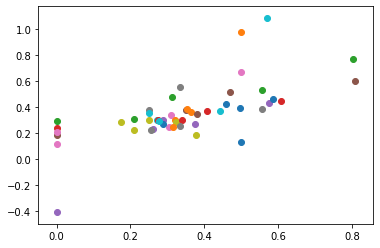

In [35]:
# Here we are using sklearn's built-in Leave-One-Out cross-validation to split the data into training sets and test sets, and calculate and expected win rate for our test set each time. 

loo_g = model_selection.LeaveOneOut()
loo_g.get_n_splits(X_g)
exp_win_rates_g = []

for train_index, test_index in loo_g.split(X_g):
    X_train, X_test = X_g[train_index], X_g[test_index]
    y_train, y_test = y_g[train_index], y_g[test_index]
    
    reg_g.fit(X_train, y_train)
    y_hat = reg_g.predict(X_test)
    
    plt.scatter(y_test, y_hat)

    exp_win_rates_g.append(float(y_hat))

In [36]:
# We can calculate the MSE to see how close our predicted values are to the true win rates.
mse(exp_win_rates_g, y_g)

0.028277159133901397

In [37]:
# Note than one of our expected win rates is less than zero, this is obviously undesiraeable as a win rate can't be negative!
# We could try other models to see if we can eliminate this error and reduce our MSE.
# Lets try ridge regression instead.
# For ridge regresion we must specify an extra paramater, alpha. Here we have just set alpha to be 0.5.
reg_g = linear_model.Ridge(alpha = 0.5)

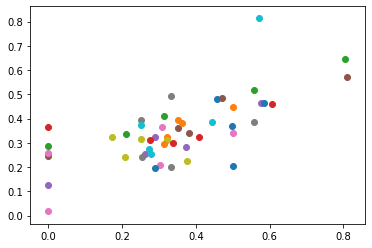

In [38]:
loo_g = model_selection.LeaveOneOut()
loo_g.get_n_splits(X_g)
exp_win_rates_g = []

for train_index, test_index in loo_g.split(X_g):
    X_train, X_test = X_g[train_index], X_g[test_index]
    y_train, y_test = y_g[train_index], y_g[test_index]
    
    reg_g.fit(X_train, y_train)
    y_hat = reg_g.predict(X_test)
    
    plt.scatter(y_test, y_hat)
    
    exp_win_rates_g.append(float(y_hat))

In [39]:
mse(exp_win_rates_g, y_g)

0.018284391586163826

In [40]:
# The MSE is marginally smaller, but more importantly all our expected win rates are greater than zero now.

0.01776095700944615

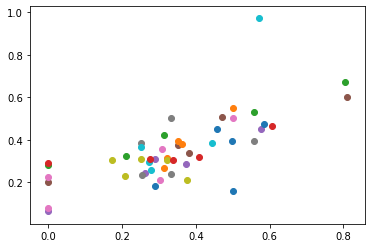

In [41]:
# What happens when we change alpha?
reg_g = linear_model.Ridge(alpha = 0.1)

loo_g = model_selection.LeaveOneOut()
loo_g.get_n_splits(X_g)
exp_win_rates_g = []

for train_index, test_index in loo_g.split(X_g):
    X_train, X_test = X_g[train_index], X_g[test_index]
    y_train, y_test = y_g[train_index], y_g[test_index]
    
    reg_g.fit(X_train, y_train)
    y_hat = reg_g.predict(X_test)
    
    plt.scatter(y_test, y_hat)
    
    exp_win_rates_g.append(float(y_hat))

mse(exp_win_rates_g, y_g)

In [42]:
# Clearly changing alpha affects our model, so it makes sense to choose alpha such that the mse is as low as possible.
# We can write a function to determine the optimal alpha.
def optimal_alpha(X,y):
    alpha_vals = np.arange(0.01, 1.00, 0.01)
    mse_vals = []

    for i in alpha_vals:
        reg = linear_model.Ridge(alpha = i)

        loo = model_selection.LeaveOneOut()
        loo.get_n_splits(X)
        exp_win_rates = []
    
        for train_index, test_index in loo.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
    
            reg.fit(X_train, y_train)
            y_hat = reg.predict(X_test)
            exp_win_rates.append(float(y_hat))
    
        mse_vals.append(mse(exp_win_rates, y))
    
    return(alpha_vals[mse_vals.index(min(mse_vals))])

In [43]:
# Now use this function to find optimal value for our model.
alpha_g = optimal_alpha(X_g, y_g)
alpha_g

0.19

0.0175107094308526

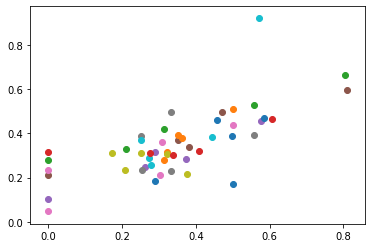

In [44]:
reg_g = linear_model.Ridge(alpha = alpha_g)

loo_g = model_selection.LeaveOneOut()
loo_g.get_n_splits(X_g)
exp_win_rates_g = []

for train_index, test_index in loo_g.split(X_g):
    X_train, X_test = X_g[train_index], X_g[test_index]
    y_train, y_test = y_g[train_index], y_g[test_index]
    
    reg_g.fit(X_train, y_train)
    y_hat = reg_g.predict(X_test)
    
    plt.scatter(y_test, y_hat)
    
    exp_win_rates_g.append(float(y_hat))

mse(exp_win_rates_g, y_g)

In [45]:
# As usual we convert our list into a table.
exp_win_g = pd.DataFrame({'Player':avg_g['Name'], 'Expected win rate':exp_win_rates_g, 'true win rate':avg_g['Win rate']})

In [46]:
exp_win_g.head()

,Player,Expected win rate,true win rate
0,Bernd Leno,0.459130,0.458333
1,Emiliano Martinez,0.510128,0.500000
2,Orjan Nyland,0.279189,0.000000
3,Jed Steer,0.313800,0.000000
4,Tom Heaton,0.315158,0.288288


Text(0, 0.5, 'win rate')

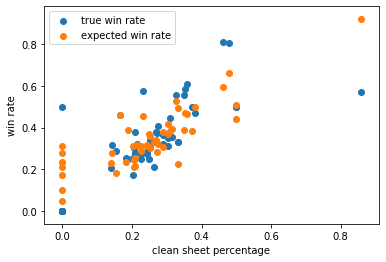

In [47]:
# An exampel to show how our model performs.
plt.scatter(X_g[:, 2],y_g)
plt.scatter(X_g[:, 2],exp_win_g['Expected win rate'])
plt.legend(['true win rate', 'expected win rate'])
plt.xlabel('clean sheet percentage')
plt.ylabel('win rate')

In [48]:
# DEFENDERS
X_d = np.array(avg_d.drop(['Name', 'Win rate', 'Loss rate'], 1))

In [49]:
y_d = np.array(avg_d['Win rate'])

In [50]:
alpha_d = optimal_alpha(X_d, y_d)
alpha_d

0.46

0.018934224666737998

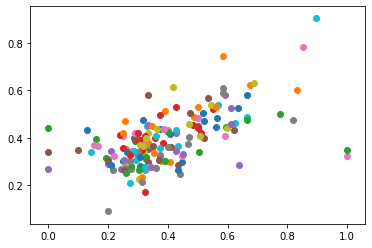

In [51]:
reg_d = linear_model.Ridge(alpha = alpha_d)

loo_d = model_selection.LeaveOneOut()
loo_d.get_n_splits(X_d)
exp_win_rates_d = []

for train_index, test_index in loo_d.split(X_d):
    X_train, X_test = X_d[train_index], X_d[test_index]
    y_train, y_test = y_d[train_index], y_d[test_index]
    
    reg_d.fit(X_train, y_train)
    y_hat = reg_d.predict(X_test)
    
    plt.scatter(y_test, y_hat)
    
    exp_win_rates_d.append(float(y_hat))
    
mse(exp_win_rates_d, y_d)

In [52]:
exp_win_d = pd.DataFrame({'Player':avg_d['Name'], 'Expected win rate':exp_win_rates_d, 'true win rate':avg_d['Win rate']})

In [53]:
exp_win_d

,Player,Expected win rate,true win rate
0,Hector Bellerin,0.446219,0.561644
1,Sokratis,0.487077,0.487179
2,Rob Holding,0.447625,0.593750
3,Shkodran Mustafi,0.522971,0.552941
4,Konstantinos Mavropanos,0.420621,0.428571
...,...,...,...
168,Willy Boly,0.436261,0.363636
169,Jonny,0.356862,0.375000
170,Ruben Vinagre,0.264541,0.434783
171,Max Kilman,0.528801,0.500000


Text(0, 0.5, 'win rate')

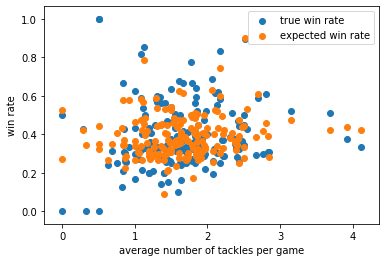

In [54]:
#An example to show how our model performs.
plt.scatter(X_d[:,0], y_d)
plt.scatter(X_d[:,0], exp_win_d['Expected win rate'])
plt.legend(['true win rate', 'expected win rate'])
plt.xlabel('average number of tackles per game')
plt.ylabel('win rate')

In [55]:
# MIDFIELDERS
X_m = np.array(avg_m.drop(['Name', 'Win rate', 'Loss rate'], 1))

In [56]:
y_m = np.array(avg_m['Win rate'])

In [57]:
alpha_m = optimal_alpha(X_m, y_m)
alpha_m

0.98

0.02852439304805715

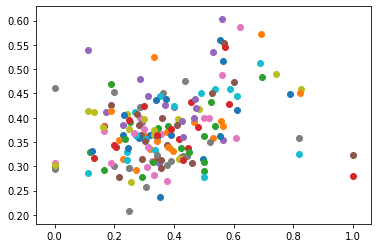

In [58]:
reg_m = linear_model.Ridge(alpha = alpha_m)

loo_m = model_selection.LeaveOneOut()
loo_m.get_n_splits(X_m)
exp_win_rates_m = []

for train_index, test_index in loo_m.split(X_m):
    X_train, X_test = X_m[train_index], X_m[test_index]
    y_train, y_test = y_m[train_index], y_m[test_index]
    
    reg_m.fit(X_train, y_train)
    y_hat = reg_m.predict(X_test)
    
    plt.scatter(y_test, y_hat)
    
    exp_win_rates_m.append(float(y_hat))

mse(exp_win_rates_m, y_m)

In [59]:
exp_win_m = pd.DataFrame({'Player':avg_m['Name'], 'Expected win rate':exp_win_rates_m, 'true win rate':avg_m['Win rate']})

In [60]:
exp_win_m

,Player,Expected win rate,true win rate
0,Mesut Ozil,0.560670,0.554913
1,Lucas Torreira,0.391666,0.468085
2,Ainsley Maitland-Niles,0.363024,0.500000
3,Matteo Guendouzi,0.432012,0.458333
4,Granit Xhaka,0.535448,0.531532
...,...,...,...
170,Ruben Neves,0.437805,0.372549
171,Morgan Gibbs-White,0.340234,0.379310
172,Romain Saiss,0.329367,0.451613
173,Joao Moutinho,0.377560,0.388889


Text(0, 0.5, 'win rate')

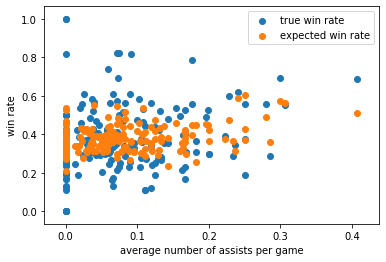

In [61]:
#An example to show how our model performs.
plt.scatter(X_m[:,2], y_m)
plt.scatter(X_m[:,2], exp_win_m['Expected win rate'])
plt.legend(['true win rate', 'expected win rate'])
plt.xlabel('average number of assists per game')
plt.ylabel('win rate')

In [62]:
# FORWARDS
X_f = np.array(avg_f.drop(['Name', 'Win rate', 'Loss rate'], 1))

In [63]:
y_f = np.array(avg_f['Win rate'])

In [64]:
alpha_f = optimal_alpha(X_f, y_f)
alpha_f

0.06999999999999999

0.02843110177380146

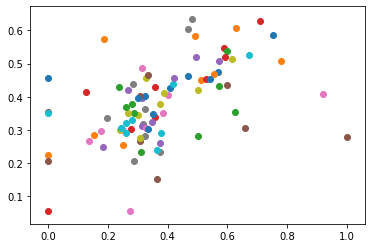

In [65]:
reg_f = linear_model.Ridge(alpha = alpha_f)

loo_f = model_selection.LeaveOneOut()
loo_f.get_n_splits(X_f)
exp_win_rates_f = []

for train_index, test_index in loo_m.split(X_f):
    X_train, X_test = X_f[train_index], X_f[test_index]
    y_train, y_test = y_f[train_index], y_f[test_index]
    
    reg_f.fit(X_train, y_train)
    y_hat = reg_f.predict(X_test)
    
    plt.scatter(y_test, y_hat)
    
    exp_win_rates_f.append(float(y_hat))

mse(exp_win_rates_f, y_f)

In [66]:
exp_win_f = pd.DataFrame({'Player':avg_f['Name'], 'Expected win rate':exp_win_rates_f, 'true win rate':avg_f['Win rate']})

In [67]:
exp_win_f

,Player,Expected win rate,true win rate
0,Alexandre Lacazette,0.462672,0.467532
1,Pierre-Emerick Aubameyang,0.583533,0.492308
2,Reiss Nelson,0.354018,0.625000
3,Nicolas Pepe,0.427894,0.357143
4,Bukayo Saka,0.260530,0.375000
...,...,...,...
86,Diogo Jota,0.349694,0.382979
87,Adama Traore,0.334614,0.197531
88,Raul Jimenez,0.411850,0.388889
89,Patrick Cutrone,0.238155,0.363636


Text(0, 0.5, 'win rate')

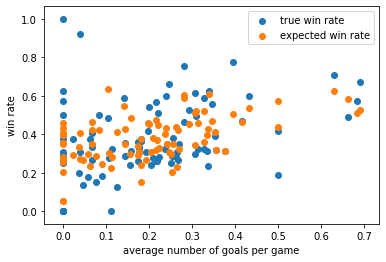

In [68]:
#An example to show how our model performs.
plt.scatter(X_f[:,0], y_f)
plt.scatter(X_f[:,0], exp_win_f['Expected win rate'])
plt.legend(['true win rate', 'expected win rate'])
plt.xlabel('average number of goals per game')
plt.ylabel('win rate')

In [69]:
# Now I am comparing the players' win rates against their wages. As usual a seperate table is created for each position.

#GOALKEEPERS
names_g = []
salaries_g = []
expw2_g = []
tw2_g = []
for i in range(len(salaries2)):
    for j in range(len(exp_win_g)):
        if salaries2['Player'][i] == exp_win_g['Player'][j]:
            names_g.append(salaries2['Player'][i])
            salaries_g.append(salaries2['Annual salary'][i])
            expw2_g.append(exp_win_g['Expected win rate'][j])
            tw2_g.append(exp_win_g['true win rate'][j])                             

In [70]:
expw_vs_salary_g = pd.DataFrame({'Player':names_g, 'true win rate':tw2_g, 'expected win rate':expw2_g, 'salary':salaries_g})

In [71]:
expw_vs_salary_g.head()

,Player,true win rate,expected win rate,salary
0,Bernd Leno,0.458333,0.459130,"£5,200,000"
1,Emiliano Martinez,0.500000,0.510128,"£1,040,000"
2,Orjan Nyland,0.000000,0.279189,"£1,040,000"
3,Jed Steer,0.000000,0.313800,"£416,000"
4,Tom Heaton,0.288288,0.315158,"£2,184,000"


In [72]:
# DEFENDERS
names_d = []
salaries_d = []
expw2_d = []
tw2_d = []
for i in range(len(salaries2)):
    for j in range(len(exp_win_d)):
        if salaries2['Player'][i] == exp_win_d['Player'][j]:
            names_d.append(salaries2['Player'][i])
            salaries_d.append(salaries2['Annual salary'][i])
            expw2_d.append(exp_win_d['Expected win rate'][j])
            tw2_d.append(exp_win_d['true win rate'][j])  

In [73]:
expw_vs_salary_d = pd.DataFrame({'Player':names_d, 'true win rate':tw2_d, 'expected win rate':expw2_d, 'salary':salaries_d})

In [74]:
expw_vs_salary_d

,Player,true win rate,expected win rate,salary
0,Hector Bellerin,0.561644,0.446219,"£5,720,000"
1,Rob Holding,0.593750,0.447625,"£1,300,000"
2,Shkodran Mustafi,0.552941,0.522971,"£4,680,000"
3,Konstantinos Mavropanos,0.428571,0.420621,"£1,300,000"
4,Sead Kolasinac,0.500000,0.451463,"£5,200,000"
...,...,...,...,...
146,Declan Rice,0.350649,0.367375,"£156,000"
147,Matt Doherty,0.388889,0.437799,"£520,000"
148,Ryan Bennett,0.359223,0.273834,"£1,040,000"
149,Ruben Vinagre,0.434783,0.264541,"£1,560,000"


In [75]:
# MIDFIELDERS
names_m = []
salaries_m = []
expw2_m = []
tw2_m = []
for i in range(len(salaries2)):
    for j in range(len(exp_win_m)):
        if salaries2['Player'][i] == exp_win_m['Player'][j]:
            names_m.append(salaries2['Player'][i])
            salaries_m.append(salaries2['Annual salary'][i])
            expw2_m.append(exp_win_m['Expected win rate'][j])
            tw2_m.append(exp_win_m['true win rate'][j])  

In [76]:
expw_vs_salary_m = pd.DataFrame({'Player':names_m, 'true win rate':tw2_m, 'expected win rate':expw2_m, 'salary':salaries_m})

In [77]:
expw_vs_salary_m

,Player,true win rate,expected win rate,salary
0,Mesut Ozil,0.554913,0.560670,"£18,200,000"
1,Lucas Torreira,0.468085,0.391666,"£3,900,000"
2,Ainsley Maitland-Niles,0.500000,0.363024,"£1,820,000"
3,Matteo Guendouzi,0.458333,0.432012,"£2,080,000"
4,Granit Xhaka,0.531532,0.535448,"£5,200,000"
...,...,...,...,...
137,Conor Coady,0.400000,0.424759,"£780,000"
138,Ruben Neves,0.372549,0.437805,"£2,600,000"
139,Morgan Gibbs-White,0.379310,0.340234,"£78,000"
140,Romain Saiss,0.451613,0.329367,"£1,144,000"


In [78]:
# FORWARDS
names_f = []
salaries_f = []
expw2_f = []
tw2_f = []
for i in range(len(salaries2)):
    for j in range(len(exp_win_f)):
        if salaries2['Player'][i] == exp_win_f['Player'][j]:
            names_f.append(salaries2['Player'][i])
            salaries_f.append(salaries2['Annual salary'][i])
            expw2_f.append(exp_win_f['Expected win rate'][j])
            tw2_f.append(exp_win_f['true win rate'][j]) 

In [79]:
expw_vs_salary_f = pd.DataFrame({'Player':names_f, 'true win rate':tw2_f, 'expected win rate':expw2_f, 'salary':salaries_f})

In [80]:
expw_vs_salary_f

,Player,true win rate,expected win rate,salary
0,Alexandre Lacazette,0.467532,0.462672,"£9,467,273"
1,Pierre-Emerick Aubameyang,0.492308,0.583533,"£10,400,000"
2,Nicolas Pepe,0.357143,0.427894,"£7,280,000"
3,Jonathan Kodjia,0.000000,0.353739,"£1,820,000"
4,Callum Wilson,0.317757,0.317491,"£3,120,000"
...,...,...,...,...
68,Albian Ajeti,0.000000,0.205494,-
69,Adama Traore,0.197531,0.334614,"£2,236,000"
70,Raul Jimenez,0.388889,0.411850,"£2,144,000"
71,Patrick Cutrone,0.363636,0.238155,"£3,272,000"


In [81]:
def best_players(position, budget, n):
    '''
    Returns the top n players with the highest expected win rates for a given position and budget.
    Position argument can take the following inputs: 'Goalkeeper', 'Defender', 'Midfielder', 'Forward'
    Budget argument must be a string of an amount of money in pounds (e.g. £1,000,000).
    '''
    exp_wins = []
    budget_players = []
    if position == 'Goalkeeper':
        for wages in salaries_g:
            if int(wages) <= int(Money(budget)):
                budget_players.append(names_g[salaries_g.index(wages)])
                exp_wins.append(expw2_g[salaries_g.index(wages)])
    if position == 'Defender':
        for wages in salaries_d:
            if int(wages) <= int(Money(budget)):
                budget_players.append(names_d[salaries_d.index(wages)])
                exp_wins.append(expw2_d[salaries_d.index(wages)])
    if position == 'Midfielder':
        for wages in salaries_m:
            if int(wages) <= int(Money(budget)):
                budget_players.append(names_m[salaries_m.index(wages)])
                exp_wins.append(expw2_m[salaries_m.index(wages)])
    if position == 'Forward':
        for wages in salaries_f:
            if int(wages) <= int(Money(budget)):
                budget_players.append(names_f[salaries_f.index(wages)])
                exp_wins.append(expw2_f[salaries_f.index(wages)])
    top_n = []
    for i in range(n):
        ind = exp_wins.index(max(exp_wins))
        top_n.append(budget_players[ind])
        exp_wins.pop(ind)
        budget_players.pop(ind)
    return(top_n)

In [82]:
def build_team(formation, budget):
    '''
    Builds the best team possible for a given formation and budget. Formations must be lists of three integers (e.g [4,4,2]
    and [3,5,2] are both appropriate formations.)
    '''
    # Split the budget up so that it can be spread across 11 players.
    budget_per_player = int(int(Money(budget)) / 11)
    spendings = 0
    overall_expw = 0
    
    goalkeeper = best_players('Goalkeeper', f'£{budget_per_player}', 1)
    spendings += int(salaries_g[names_g.index(goalkeeper[0])])
    overall_expw += expw2_g[names_g.index(goalkeeper[0])]
    
    defenders = best_players('Defender', f'£{budget_per_player}', formation[0])
    for d in defenders:
        spendings += int(salaries_d[names_d.index(d)])
        overall_expw += expw2_d[names_d.index(d)]
        
    midfielders = best_players('Midfielder', f'£{budget_per_player}', formation[1])
    for m in midfielders:
        spendings += int(salaries_m[names_m.index(m)])
        overall_expw += expw2_m[names_m.index(m)]
    
    forwards = best_players('Forward', f'£{budget_per_player}', formation[2])
    for f in forwards:
        spendings += int(salaries_f[names_f.index(f)])
        overall_expw += expw2_f[names_f.index(f)]
            
    overall_expw = (overall_expw) / 11

    print(f'{goalkeeper}\n{defenders}\n{midfielders}\n{forwards}')
    print(f'Total annual salaries: £{spendings}\nExpected win rate: {overall_expw}')

In [87]:
build_team([3,4,3],'£1,000,000,000')

['Sergio Romero']
['Oleksandr Zinchenko', 'Aymeric Laporte', 'Nicolas Otamendi']
['Paul Pogba', 'Youri Tielemans', 'David Silva', 'Mesut Ozil']
['Alex Iwobi', 'Mohamed Salah', 'Roberto Firmino']
Total annual salaries: £85958000
Expected win rate: 0.6756348835207645


In [84]:
# Generally it may be mroe useful to build a full squad rather than a single 11-man side. Here we write a function that lets you build a custom squad of 25 players, given a certain budget, letting the user choose how many players they wan't for each position.
def build_squad(budget):
    budget_per_player = int(int(Money(budget)) / 25)
    spendings = 0
    overall_expw = 0
    
    no_g = int(input(f'How many goalkeepers do you want? (25 players left)'))
    goalkeepers = best_players('Goalkeeper', f'£{budget_per_player}', no_g)
    for g in goalkeepers:
        spendings += int(salaries_g[names_g.index(g)])
        overall_expw += expw2_g[names_g.index(g)]
    
    no_d = int(input(f'How many defenders do you want? ({25 - no_g} players left)'))
    defenders = best_players('Defender', f'£{budget_per_player}', no_d)
    for d in defenders:
        spendings += int(salaries_d[names_d.index(d)])
        overall_expw += expw2_d[names_d.index(d)]
    
    no_m = int(input(f'How many midfielders do you want? ({25 - no_g - no_d} players left)'))
    midfielders = best_players('Midfielder', f'£{budget_per_player}', no_m)
    for m in midfielders:
        spendings += int(salaries_m[names_m.index(m)])
        overall_expw += expw2_m[names_m.index(m)]
    
    no_f = 25 - no_m - no_d - no_g
    forwards = best_players('Forward', f'£{budget_per_player}', no_f)
    for f in forwards:
        spendings += int(salaries_f[names_f.index(f)])
        overall_expw += expw2_f[names_f.index(f)]

    overall_expw = (overall_expw) / 25
    
    print('FULL SQUAD:')
    print('\nGoalkeepers:')
    for g in goalkeepers:
        print(g)
    print('\nDefenders:')
    for d in defenders:
        print(d)
    print('\nMidfielders:')
    for m in midfielders:
        print(m)
    print('\nForwards:')
    for f in forwards:
        print(f)    
    print(f'\nTotal annual salaries: £{spendings}\nExpected win rate: {overall_expw}')    

In [86]:
build_squad('£9,000,000,000')

How many goalkeepers do you want? (25 players left)4
How many defenders do you want? (21 players left)8
How many midfielders do you want? (13 players left)8
FULL SQUAD:

Goalkeepers:
Sergio Romero
Kepa Arrizabalaga
Emiliano Martinez
Vicente Guaita

Defenders:
Oleksandr Zinchenko
Aymeric Laporte
Nicolas Otamendi
Joel Matip
Joao Cancelo
Antonio Rudiger
Adam Webster
John Stones

Midfielders:
Paul Pogba
Youri Tielemans
David Silva
Mesut Ozil
Granit Xhaka
Mateo Kovacic
Kevin De Bruyne
Ilkay Gundogan

Forwards:
Alex Iwobi
Mohamed Salah
Roberto Firmino
Riyad Mahrez
Leroy Sane

Total annual salaries: £164825000
Expected win rate: 0.606666549968123
